# Model comparison benchmark analysis

We compare a number of compositional (and non-compositional) models to scCODA's performance on artificial data.
For the data generation parameters and procedure, see the paper or *generate_data*.

We compare the following models:
- scCODA
- Simple Bayesian Dirichlet-Multinomial model
- ALDEx2 (Fernandes et al., 2014)
- ancom (Mandal et al., 2015)
- scDC (Cao et al., 2019)
- dirichReg (Maier, 2014)
- ALR transform and t-test
- ALR transform and Wilcoxon Rank-sum test
- Poisson regression
- t-test

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import numpy as np

import warnings
warnings.filterwarnings("ignore")

We want to show one example benchmarking dataset that captures the essence of scCODA:
Compositional analysis on low-replicate data.
Thus, we choose one where we have an effect that is large (log-fold = 2)
and the replicate number is low (2 samples per group).

In [47]:
save_path = "../../sccoda_benchmark_data/model_comparison/data_model_comparison/"

# read generation parameters and find one where we have an increase that is large
# and replicate number is low
gen_params = pd.read_csv(save_path + "generation_parameters", index_col=0)
print(f'relevant indices: {gen_params.loc[(gen_params["n_controls"]==2) & (gen_params["log-fold increase"]==2) & (gen_params["Base"]==1000)].index}')

# choose one dataset as example (e.g. number 2304 one with these properties)
example_index = 4744
example_params = gen_params.iloc[example_index, :]

relevant indices: Int64Index([4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750,
            4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759],
           dtype='int64')


We select one dataset that matches these criteria (here the fourth).
The raw counts look like this:

In [48]:
# read all generated data and pick the one we selected
datasets = ad.read_h5ad(save_path + "generated_data")
example_data = datasets[datasets.obs["dataset_no"] == example_index]

print(example_data.X)


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


[[ 906. 1370. 1056.  861.  807.]
 [1288.  804. 1061.  895.  952.]
 [3734.  275.  264.  270.  457.]
 [4038.  244.  156.  282.  280.]]


First, a barplot of the dataset to gain some intuition:


The first cell type increases from the control to the case category,
while the others behave the same (slightly decrease).
This decrease is due to compositional effects and should not be picked up as significant by a statistical method


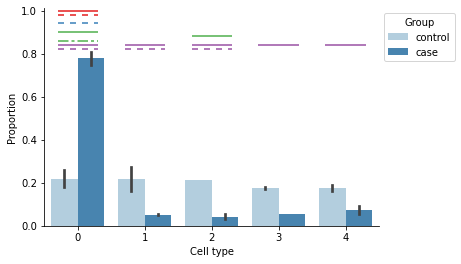

In [72]:
X = example_data.X
cell_types = example_data.var.index
obs = example_data.obs

# Aggregate data by category

count_df = pd.DataFrame(np.divide(X, np.sum(X, axis=1, keepdims=True)), columns=cell_types, index=obs.index).\
    merge(obs["x_0"], left_index=True, right_index=True)
plot_df = pd.melt(count_df, id_vars="x_0", var_name="Cell type", value_name="count")

# barplot
d = sns.barplot(x="Cell type", y="count", hue="x_0", data=plot_df,
                palette='Blues')

loc, labels = plt.xticks()

handles, labels = d.get_legend_handles_labels()
plt.legend(handles=handles, labels=["control", "case"], loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title="Group")

d.set(xlabel="Cell type", ylabel="Proportion", ylim=(0,1.01))
sns.despine()

# manually add credible effects for each method (see below)
dashes=[(1,0), (4, 4), (7, 2, 2, 2)]
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

plt.axhline(y = 1, xmin=0.04, xmax = 0.16, color=colors[0], dashes=dashes[0])
plt.axhline(y = 0.98, xmin=0.04, xmax = 0.16, color=colors[0], dashes=dashes[1])
plt.axhline(y = 0.94, xmin=0.04, xmax = 0.16, color=colors[1], dashes=dashes[1])
plt.axhline(y = 0.9, xmin=0.04, xmax = 0.16, color=colors[2], dashes=dashes[0])
plt.axhline(y = 0.86, xmin=0.04, xmax = 0.16, color=colors[2], dashes=dashes[2])
plt.axhline(y = 0.84, xmin=0.04, xmax = 0.16, color=colors[3], dashes=dashes[0])
plt.axhline(y = 0.82, xmin=0.04, xmax = 0.16, color=colors[3], dashes=dashes[1])

plt.axhline(y = 0.88, xmin=0.44, xmax = 0.56, color=colors[2], dashes=dashes[0])
plt.axhline(y = 0.84, xmin=0.44, xmax = 0.56, color=colors[3], dashes=dashes[0])
plt.axhline(y = 0.82, xmin=0.44, xmax = 0.56, color=colors[3], dashes=dashes[1])

plt.axhline(y = 0.84, xmin=0.24, xmax = 0.36, color=colors[3], dashes=dashes[0])
plt.axhline(y = 0.82, xmin=0.24, xmax = 0.36, color=colors[3], dashes=dashes[1])

plt.axhline(y = 0.84, xmin=0.64, xmax = 0.76, color=colors[3], dashes=dashes[0])
plt.axhline(y = 0.84, xmin=0.84, xmax = 0.96, color=colors[3], dashes=dashes[0])


plot_path = "../../sccoda_benchmark_data/model_comparison/model_comparison_plots/"
plt.savefig(plot_path + "/model_comparison_example_data_grouped.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "/model_comparison_example_data_grouped.png", format="png", bbox_inches="tight")

plt.show()


Now, we read in the benchmark results and see how the models perform on it.
(Note: Model "Haber" is the Poisson regression model from Haber et al.)

Only some methods (scCODA, simpleDM, DirichReg, ancom) correctly capture only the intended effect,
while non-compositional methods (Poisson regression, t-test) produce false-positive results.
The other methods (ALDEx2, scDC, ALR transformed tests) do not caputre the effect or are not 100% accurate.

In [50]:
save_path = "../../sccoda_benchmark_data/model_comparison/data_model_comparison/"

all_res = pd.read_csv(save_path + "benchmark_results", index_col=0)

# select the results corresponding to our example data
bools = [(all_res[cov] == example_params[cov]).tolist() for cov in example_params.index]
samples = [all([b[i] for b in bools]) for i in range(len(bools[0]))]
example_results = all_res.loc[samples & (all_res.index == 4), ["tp", "tn", "fp", "fn", "mcc", "model"]]

print(example_results)


   tp  tn  fp  fn       mcc         model
4   0   3   0   1  0.000000    ALDEx2_alr
4   0   4   0   1  0.000000          scdc
4   1   0   4   0  0.000000         Haber
4   1   4   0   0  1.000000        sccoda
4   1   2   2   0  0.408248         ttest
4   1   4   0   0  1.000000     simple_dm
4   1   4   0   0  1.000000     dirichreg
4   0   4   0   1  0.000000  alr_wilcoxon
4   1   3   1   0  0.612372     alr_ttest
4   1   4   0   0  1.000000         ancom


We also want to get an overview over how the methods perform on all datasets, depending on sample size and effect size.

Plotting preparation...

In [6]:
# Get only relevant models for plots
models_rel = ["sccoda", "simple_dm", "scdc", "ancom", "ALDEx2_alr", "alr_ttest", "alr_wilcoxon", "dirichreg", "Haber", "ttest"]
plot_df = all_res.loc[all_res["model"].isin(models_rel)]

In [7]:
# Plotting preparation: Determine linestyles and colors manually
plot_df.loc[:, 'model'] = pd.Categorical(plot_df['model'], models_rel)
plot_df = plot_df.sort_values("model")

linestyles = dict(zip(models_rel, [0, 1, 0, 1, 3, 0, 1, 3, 0, 1]))
colors = dict(zip(models_rel, [0, 0, 1, 1, 1, 2, 2, 2, 3, 3]))

plot_df.loc[:, "linestyle"] = [linestyles[x] for x in plot_df["model"]]
plot_df.loc[:, "color"] = [colors[x] for x in plot_df["model"]]

In [8]:
# Nice label names for legend
leg_labels = ["scCODA", "Simple DM", "scDC", "ancom", "ALDEx2",
              "ALR + t", "ALR + Wilcoxon", "Dirichlet regression", "Poisson regression", "t-test"]
print(leg_labels)

['scCODA', 'Simple DM', 'scDC', 'ancom', 'ALDEx2', 'ALR + t', 'ALR + Wilcoxon', 'Dirichlet regression', 'Poisson regression', 't-test']


Plots of MCC by no. of replicates and effect size. 

We see that sccoda outperforms the other models for low sample sizes and shows comparable performance for higher ones.

The non-compositional models (Poisson regression, t-test) decrease in MCC for large effects due to higher numbers of False Positives.

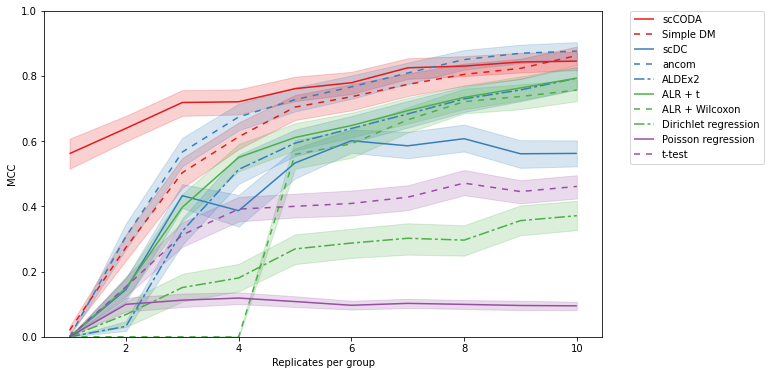

In [9]:
# Plot sample size vs MCC

plot_path = "../../sccoda_benchmark_data/model_comparison/model_comparison_plots/"
palette = sns.color_palette(['#e41a1c','#377eb8','#4daf4a','#984ea3'])

# Plot for concept fig
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=plot_df, x="n_controls", y="mcc",
             hue="color",
             palette=palette,
             style="linestyle",
             dashes=[(1,0), (4, 4), (7, 2, 2, 2)],
             ax=ax,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           labels=leg_labels
           )
ax.set(xlabel="Replicates per group", ylabel="MCC", ylim=[0,1])

# plt.savefig(plot_path + "/model_comparison_replicates_confint_extended.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "/model_comparison_replicates_confint_extended.png", format="png", bbox_inches="tight")

plt.show()

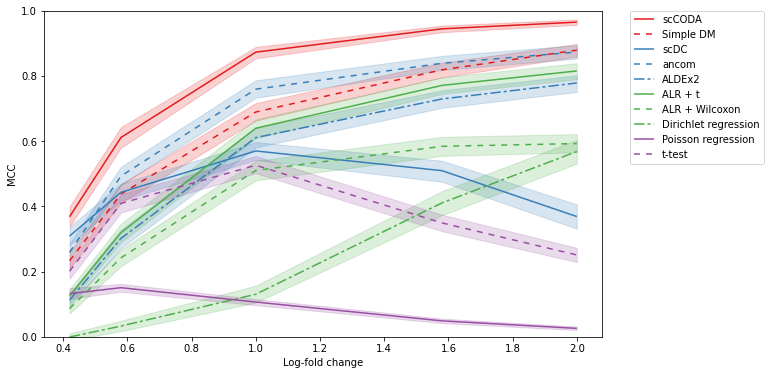

In [10]:
# Plot effect size vs MCC

# Plot for concept fig
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=plot_df, x="log-fold increase", y="mcc",
             hue="color",
             palette=palette,
             style="linestyle",
             dashes=[(1,0), (4, 4), (7, 2, 2, 2)],
             ax=ax,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=leg_labels)
ax.set(xlabel="Log-fold change", ylabel="MCC", ylim=[0,1])

# plt.savefig(plot_path + "/model_comparison_logfold_confint_extended.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "/model_comparison_logfold_confint_extended.png", format="png", bbox_inches="tight")

plt.show()


Average MCC for all models: Nothing new here, scCODA performs best on average.

In [11]:
# Avg. mcc for all models:

avg_mcc = all_res.groupby("model").agg({"mcc": "mean"}).sort_values("mcc", ascending=False)
avg_mcc.rename(index={"Haber": "poisson_reg"}, inplace=True)
print(avg_mcc)

                   mcc
model                 
sccoda        0.752169
ancom         0.644547
simple_dm     0.611446
alr_ttest     0.533904
ALDEx2_alr    0.506408
scdc          0.438559
alr_wilcoxon  0.402978
ttest         0.347186
dirichreg     0.228239
poisson_reg   0.092821
